# Importing libraries and reading in of data 

In [353]:
import numpy as np
import pandas as pd
import re
import string
import nltk 
import tensorflow as tf
import matplotlib.pyplot as plt 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, BatchNormalization
from tensorflow.keras.layers import Conv1D, LSTM, GlobalMaxPool1D, LSTM, Bidirectional
from tensorflow import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

In [354]:
true_df.head() 

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [355]:
fake_df.head() 

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Adding integer value labels to the dataset for binary text classification

In [356]:
fake_df['label'] = 1
true_df['label'] = 0

In [357]:
fake_df.head() 

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


Here I concatenate and shuffle the data so that later on when I split the training and testing data there would be a good mix of both true and fake news data 

In [358]:
total_df = pd.concat([true_df,fake_df], axis=0, ignore_index=True)
total_df = total_df.sample(frac=1)
total_df

,title,text,subject,date,label
42942,WHY WOULD OBAMA’S SEND THEIR DAUGHTER TO NYC T...,Malia s internship with pedophile Lena Dunham ...,left-news,"Jul 28, 2015",1
6067,Tillerson gets first briefings at State Depart...,WASHINGTON (Reuters) - U.S. Secretary of State...,politicsNews,"January 24, 2017",0
8511,Trump seeks a campaign reset with Detroit econ...,DETROIT/WASHINGTON (Reuters) - Republican Dona...,politicsNews,"August 8, 2016",0
2323,Russia: Pence Balkans comments expose Washingt...,MOSCOW (Reuters) - Accusations made by U.S. Vi...,politicsNews,"August 3, 2017",0
42027,PRO-HILLARY SAUDI PRINCE JUST Gave Americans A...,"It wasn t a direct endorsement of Trump, but w...",left-news,"May 7, 2016",1
...,...,...,...,...,...
44728,SUNDAY SCREENING: PSYWAR (2010),21st Century Wire says Our weekly documentary ...,Middle-east,"July 3, 2016",1
6836,Trump to nominate Pruitt to lead U.S. environm...,WASHINGTON (Reuters) - U.S. President-elect Do...,politicsNews,"December 8, 2016",0
351,Trump says encouraging Hatch to run for re-ele...,SALT LAKE CITY (Reuters) - President Donald Tr...,politicsNews,"December 4, 2017",0
729,Democrats ride grassroots wave to major stateh...,(Reuters) - Democrats claimed historic gains i...,politicsNews,"November 8, 2017",0


Drop columns which I do not require for training 

In [359]:
y = total_df['label']
total_df = total_df.drop(['text', 'subject', 'date', 'label'], axis = 1)

# Data Cleaning and Preparation

In [360]:
total_list = total_df.values.tolist()
total_size = len(total_list)

Below are the functions I defined to remove punctuations, special symbols as well as to remove stopwords and lemmatize the words 

In [361]:
def Punctuation(string): 
  
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\\,<>./?@#$%^&*_~【】â€‹ÂðŸ˜”¯'''
    
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "")
    return string

def Lemmatize(string): 
    lemmatizer = WordNetLemmatizer() 
    string = string.split()
    string = ' '.join([lemmatizer.lemmatize(w) for w in string])
    return string

def Stopwords(string): 
    string = string.split() 
    stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    string = [w for w in string if not w in stopwords]
    string = str(string)
    return string

Cleaning of data, note that I have converted the data into strings and all uppercase letters to lowercase 

In [362]:
for i in range(0, total_size):
    total_list[i] = str(total_list[i])
    total_list[i] = total_list[i].lower() 
    total_list[i] = Punctuation(total_list[i]) 
    total_list[i] = Stopwords(total_list[i])
    total_list[i] = Lemmatize(total_list[i])

Checking to ensure the data is cleaned properly 

In [363]:
check_df = pd.DataFrame(total_list, columns=['title'])
check_df.head() 

,title
0,"['would', 'obama’s', 'send', 'daughter', 'nyc'..."
1,"['tillerson', 'gets', 'first', 'briefings', 's..."
2,"['trump', 'seeks', 'campaign', 'reset', 'detro..."
3,"['russia', 'pence', 'balkans', 'comments', 'ex..."
4,"['prohillary', 'saudi', 'prince', 'gave', 'ame..."


Here I vectorize the data into a list of integers 

In [364]:
x = total_list 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)
vocab_size = len(tokenizer.word_index) + 1

onehot_train = [one_hot(word, vocab_size) for word in x_train]
onehot_test = [one_hot(word, vocab_size) for word in x_test]

Apply pad_sequences so that every sentence becomes a length of 50 and the sentences which have less than 50 will have 0's before them due to padding='pre'

In [365]:
train_pad = pad_sequences(onehot_train, padding='pre', maxlen = 50)
test_pad = pad_sequences(onehot_test, padding='pre', maxlen = 50)

Using pretrained GloVe word embeddings

In [366]:
#source: https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf-8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_matrix = create_embedding_matrix('glove.6B.50d.txt', tokenizer.word_index, 50)

# Model Building

* For the first model I am building a Convolutional Neural Network (CNN) model with word embedding of features = 50
* GlobalMaxPool1D() extracts the maximum value from the feature map of the convolutional layer
* Dropout(0.5) is used to avoid overfitting 

In [367]:
model = Sequential()

model.add(Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=50, trainable=True))
model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_pad, y_train, epochs=10, validation_split=0.3, verbose=1, batch_size=128)

Epoch 1/10
197/197 [==============================] - 5s 26ms/step - loss: 0.4487 - accuracy: 0.8025 - val_loss: 0.1643 - val_accuracy: 0.9446
Epoch 2/10
197/197 [==============================] - 4s 22ms/step - loss: 0.2081 - accuracy: 0.9340 - val_loss: 0.1364 - val_accuracy: 0.9476
Epoch 3/10
197/197 [==============================] - 4s 22ms/step - loss: 0.1445 - accuracy: 0.9553 - val_loss: 0.1376 - val_accuracy: 0.9472
Epoch 4/10
197/197 [==============================] - 5s 24ms/step - loss: 0.1180 - accuracy: 0.9619 - val_loss: 0.1586 - val_accuracy: 0.9491
Epoch 5/10
197/197 [==============================] - 5s 26ms/step - loss: 0.1034 - accuracy: 0.9681 - val_loss: 0.1734 - val_accuracy: 0.9498
Epoch 6/10
197/197 [==============================] - 5s 23ms/step - loss: 0.0943 - accuracy: 0.9697 - val_loss: 0.1965 - val_accuracy: 0.9478
Epoch 7/10
197/197 [==============================] - 4s 21ms/step - loss: 0.0719 - accuracy: 0.9694 - val_loss: 0.2377 - val_accuracy: 0.9482

Visualize training over time 

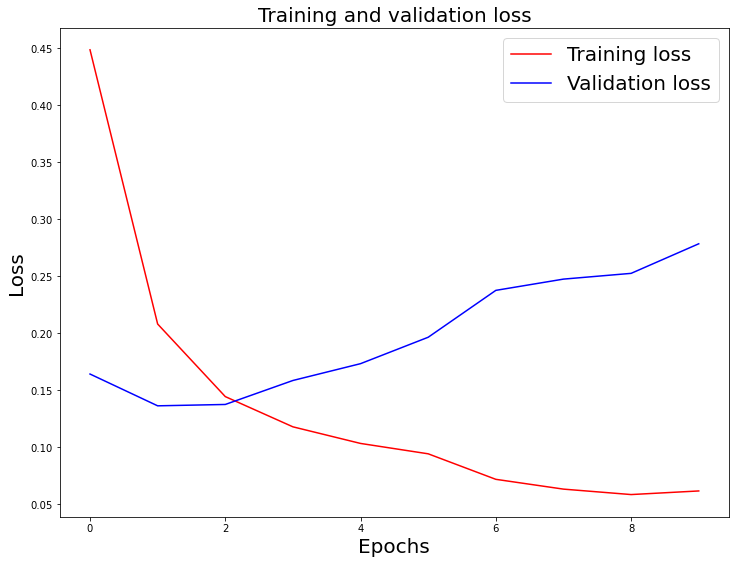

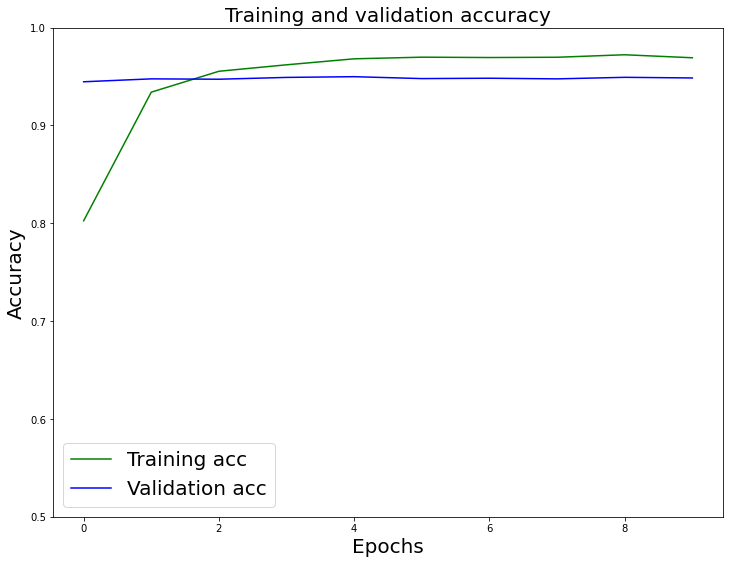

In [368]:
#source: https://www.kaggle.com/utkarshxy/fake-news-detection-using-tensorflow-99/comments#Combining-the-title-with-the-text,

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Calculating Test-set's F-1 score for model 1 

In [369]:
y_pred = model.predict_classes(test_pad) 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4318
           1       0.96      0.94      0.95      4662

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



Calculating Test-set's accuracy for model 1 

In [370]:
accuracy_score(y_test,y_pred) 

0.946325167037862

* Here I am building a second LSTM model with word of embedding features = 50
* BatchNormalization() and Dropout(0.5) are used to avoid overfitting

In [371]:
model2 = Sequential() 

model2.add(Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=50, trainable=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(32))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model2.fit(train_pad, y_train, epochs=10, validation_split=0.3, verbose=1, batch_size=128)

Epoch 1/10
197/197 [==============================] - 19s 95ms/step - loss: 0.4539 - accuracy: 0.8320 - val_loss: 0.3623 - val_accuracy: 0.9346
Epoch 2/10
197/197 [==============================] - 18s 92ms/step - loss: 0.3206 - accuracy: 0.9563 - val_loss: 0.3241 - val_accuracy: 0.9398
Epoch 3/10
197/197 [==============================] - 18s 91ms/step - loss: 0.2649 - accuracy: 0.9697 - val_loss: 0.3237 - val_accuracy: 0.9385
Epoch 4/10
197/197 [==============================] - 18s 93ms/step - loss: 0.2293 - accuracy: 0.9755 - val_loss: 0.3161 - val_accuracy: 0.9378
Epoch 5/10
197/197 [==============================] - 18s 91ms/step - loss: 0.2031 - accuracy: 0.9768 - val_loss: 0.2946 - val_accuracy: 0.9368
Epoch 6/10
197/197 [==============================] - 19s 94ms/step - loss: 0.1827 - accuracy: 0.9780 - val_loss: 0.3064 - val_accuracy: 0.9362
Epoch 7/10
197/197 [==============================] - 19s 95ms/step - loss: 0.1655 - accuracy: 0.9792 - val_loss: 0.2747 - val_accuracy:

Visualize training over time

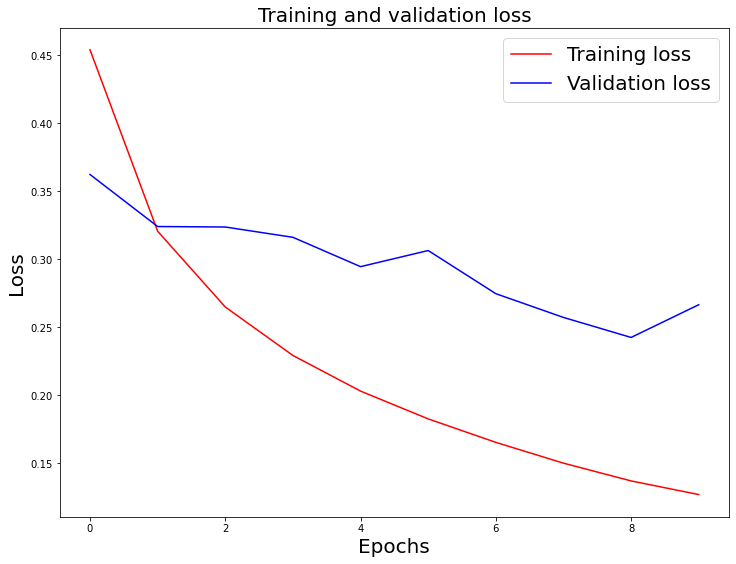

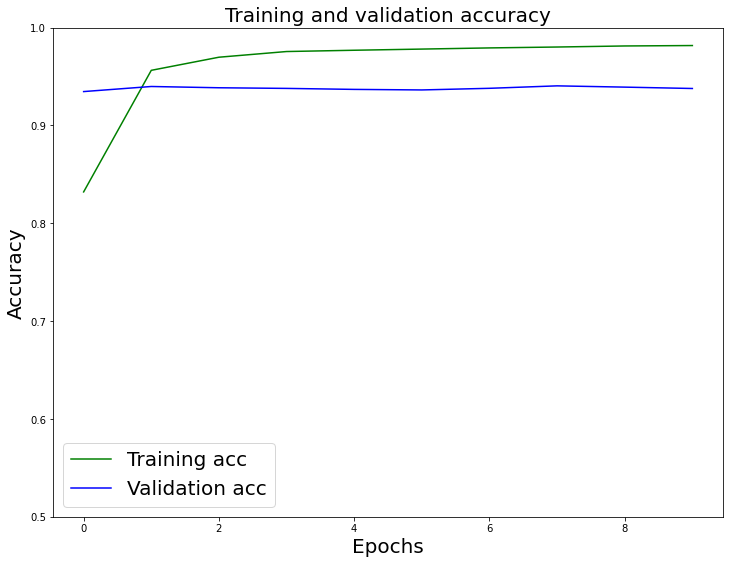

In [372]:
#source: https://www.kaggle.com/utkarshxy/fake-news-detection-using-tensorflow-99/comments#Combining-the-title-with-the-text,

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Calculating Test-set's F-1 score for model 2 

In [373]:
y_pred = model2.predict_classes(test_pad)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4318
           1       0.96      0.92      0.94      4662

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



Calculating Test-set's accuracy for model 2 

In [374]:
accuracy_score(y_test,y_pred) 

0.9429844097995546

* Here I am building a third model, Bidirectional LSTM, the difference from LSTM being that it is able to preserve information from both past and future 

In [375]:
model3 = Sequential()

model3.add(Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=50, trainable=True))
model3.add(Bidirectional(LSTM(64, return_sequences=True)))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model3.fit(train_pad, y_train, epochs=10, validation_split=0.3, verbose=1, batch_size=128)

Epoch 1/10
197/197 [==============================] - 29s 149ms/step - loss: 0.3586 - accuracy: 0.8597 - val_loss: 0.1604 - val_accuracy: 0.9428
Epoch 2/10
197/197 [==============================] - 28s 140ms/step - loss: 0.1352 - accuracy: 0.9672 - val_loss: 0.1487 - val_accuracy: 0.9518
Epoch 3/10
197/197 [==============================] - 28s 142ms/step - loss: 0.1668 - accuracy: 0.9565 - val_loss: 0.1739 - val_accuracy: 0.9379
Epoch 4/10
197/197 [==============================] - 28s 143ms/step - loss: 0.0726 - accuracy: 0.9772 - val_loss: 0.2174 - val_accuracy: 0.9262
Epoch 5/10
197/197 [==============================] - 27s 138ms/step - loss: 0.0566 - accuracy: 0.9856 - val_loss: 0.2174 - val_accuracy: 0.9393
Epoch 6/10
197/197 [==============================] - 27s 139ms/step - loss: 0.0372 - accuracy: 0.9899 - val_loss: 0.2254 - val_accuracy: 0.9439
Epoch 7/10
197/197 [==============================] - 27s 138ms/step - loss: 0.0260 - accuracy: 0.9930 - val_loss: 0.3061 - val_ac

Visualize training over time

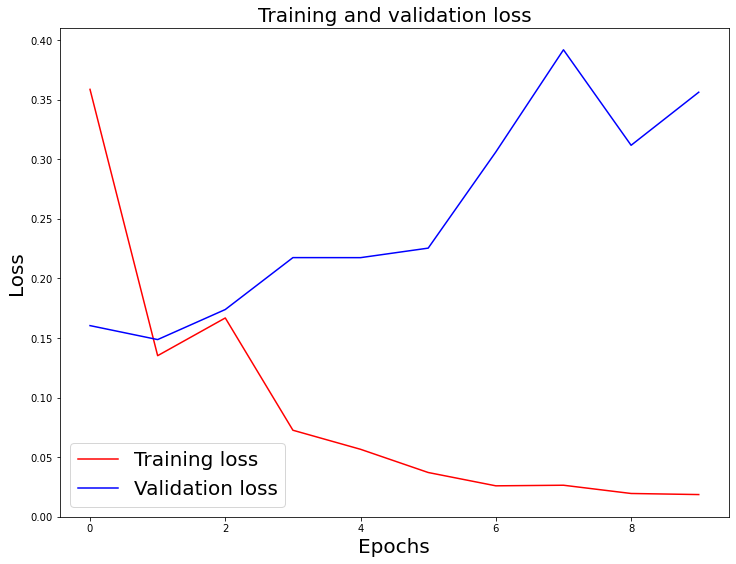

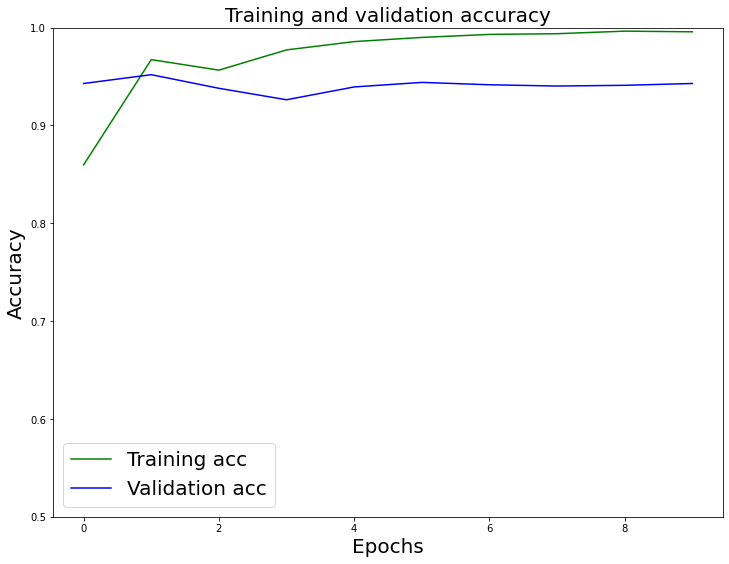

In [376]:
#source: https://www.kaggle.com/utkarshxy/fake-news-detection-using-tensorflow-99/comments#Combining-the-title-with-the-text,

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Calculating Test-set's F-1 score for model 3

In [377]:
y_pred = model3.predict_classes(test_pad)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4318
           1       0.95      0.93      0.94      4662

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



Calculating Test-set's accuracy for model 3

In [378]:
accuracy_score(y_test,y_pred) 

0.9379732739420935

# Summary

I chose to train three models, a Convolutional Neural Network (CNN) Model, Long short-term memory(LSTM) and Bidirectional LSTM.

* For the first model, I chose to train a CNN because it was the first model I built and also the one I am most comfortable with. It is easy to build and I have previous experience in it. CNN's can detect patterns of multiple by specifying kernel_size and thus can also be used for text classification with rather good results. 

* For the second model, I chose to train a LSTM because Recurrent Neural Networks (RNN) are able to deal with sequence data such as text. It can also capture meaning from the order of the words and learns from past observations. 

* For the third model, I trained a Bidirectional LSTM because it is able to learn from both past and future observations which could hopefully lead to higher text classification accuracy. 

The most preferred model would be the LSTM model because even though it has lower accuracy as compared to the CNN model, from the above visualizations, the CNN model is overfitting even after reducing the complexity of the model and including dropout. This means that while it is accurate for this test set, it is unable to generalize if a fresh test set is given to it since the test set used here came from the original training data itself. When observing the above visualizations, the LSTM model overfits much lesser than the other two models trained and has a good accuracy of 94%. Hence, I suggest LSTM as the preferred model. 